In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.

In [3]:
consensus_genes = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection_consensus_males_over_80.csv", index_col=0)

In [4]:
mask = ((ppmi_ad.obs['Age_Group'] == '>80') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [5]:
ppmi_ad = ppmi_ad[mask]

In [6]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(consensus_genes.index)]


/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_3789/3785693463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


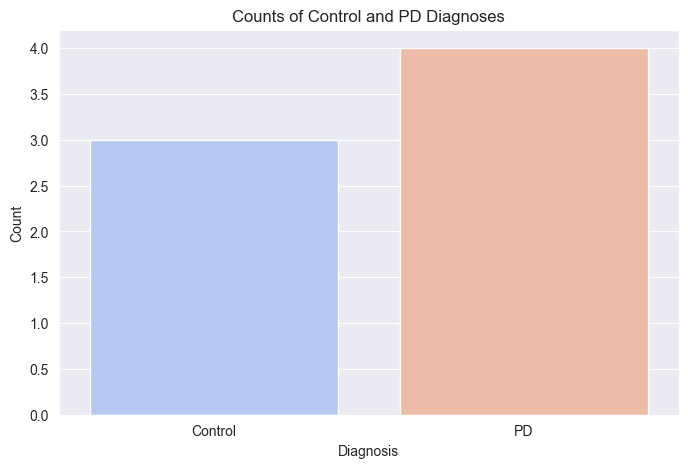

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(
    data=ppmi_ad.obs,
    x='Diagnosis',
    palette='coolwarm'
)
plt.title('Counts of Control and PD Diagnoses')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.show()

In [8]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

Smote will create synthetic samples for the minority class. SMOTE stands for synthetic minority Over-sampling technique.

In [24]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [25]:
from sklearn.model_selection import cross_val_score, LeaveOneOut

# Option 1: Leave-One-Out (LOO) - More reliable but computationally heavy
scores = cross_val_score(lr_pipeline, X_train, y_train, cv=LeaveOneOut(), scoring='roc_auc')

# Option 2: 2-Fold CV (if LOO is too slow)
scores = cross_val_score(lr_pipeline, X_train, y_train, cv=2, scoring='roc_auc')

print(f"Mean AUC: {scores.mean():.3f} (±{scores.std():.3f})")

/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/kpax/Documents/aep/study/MSC/lab/ppmi-wip/ppmi-env/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/kpax/Documents/aep/study/MSC/

Mean AUC: 1.000 (±0.000)


In [26]:
lr_pipeline.fit(X_train, y_train)
y_pred = lr_pipeline.predict(X_test)
y_proba = lr_pipeline.predict_proba(X_test)[:,1]

In [27]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



In [28]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 1.000
PR-AUC: 1.000


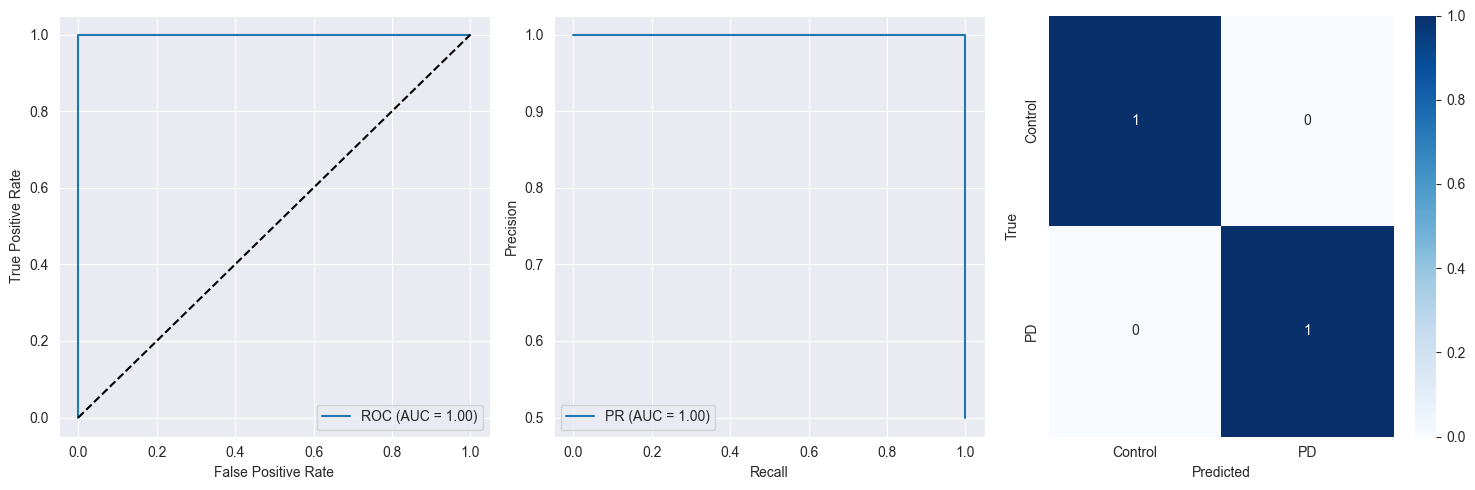

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [30]:
coefficients = pd.DataFrame({
    'ensembl_id': consensus_genes.index,
    'gene_symbol': consensus_genes['gene_symbol'],
    'coefficient': lr_pipeline.named_steps['lr'].coef_[0],
    'abs_coef': np.abs(lr_pipeline.named_steps['lr'].coef_[0])
}).sort_values('abs_coef', ascending=False)

print("\nTop 40 predictive genes:")
print(coefficients.head(40)[['gene_symbol', 'coefficient']])


Top 40 predictive genes:
                                gene_symbol  coefficient
ENSG00000259724.1                 LINC01581     0.007526
ENSG00000264569.1                   DCXR-DT    -0.007479
ENSG00000138696.10                   BMPR1B    -0.007432
ENSG00000267285.1           ENSG00000267285     0.007347
ENSG00000262967.1           ENSG00000262967     0.007329
ENSG00000172742.5                     OR4D9     0.007315
ENSG00000207312.1                 RNU6-429P     0.007291
ENSG00000161267.11                     BDH1     0.007278
ENSG00000187720.14                    THSD4     0.007277
ENSG00000141316.12                   SPACA3     0.007276
ENSG00000207156.1                 RNU6-505P     0.007258
ENSG00000236897.1           ENSG00000236897     0.007255
ENSG00000250062.5                MAPK10-AS1     0.007249
ENSG00000244953.1           ENSG00000244953    -0.007249
ENSG00000217684.2                  RPS3AP24    -0.007232
ENSG00000205858.9                    LRRC72     0.007204
ENSG0

/var/folders/qb/t7qv2b9n33n2xzbjvg_dk_4c0000gn/T/ipykernel_3789/888752835.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


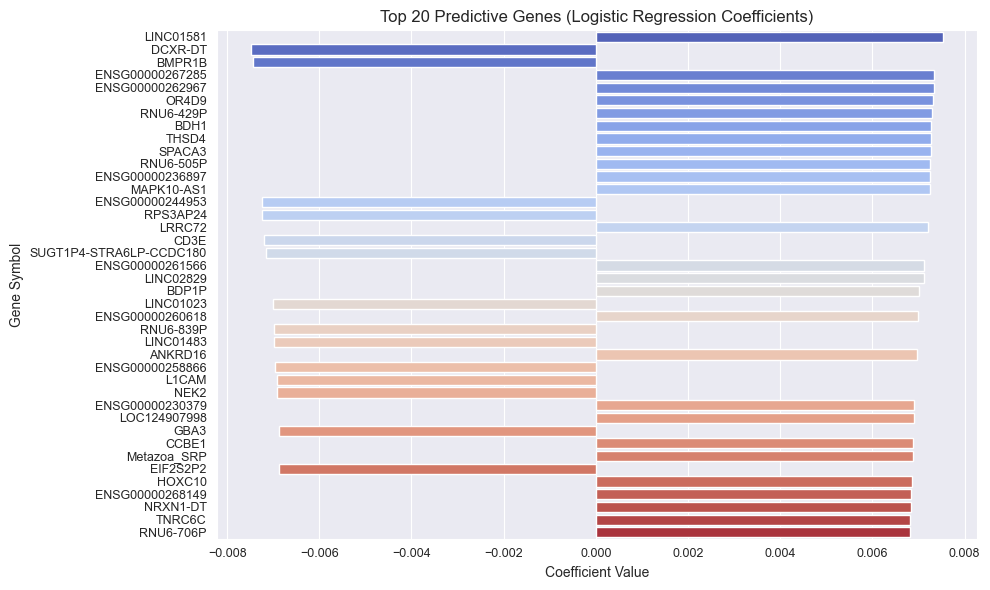

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=coefficients.head(40),
    x='coefficient',
    y='gene_symbol',
    palette='coolwarm'
)
plt.title('Top 20 Predictive Genes (Logistic Regression Coefficients)')
plt.xlabel('Coefficient Value')
plt.ylabel('Gene Symbol')
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)
plt.tight_layout()
plt.show()

### Precision-Recall Tradeoff (best for imbalanced data)

In [20]:
optimal_idx = np.argmax(precision * recall)
optimal_threshold_pr = thresholds[optimal_idx]
print(f"Optimal PR Threshold: {optimal_threshold_pr:.3f}")

Optimal PR Threshold: 0.027


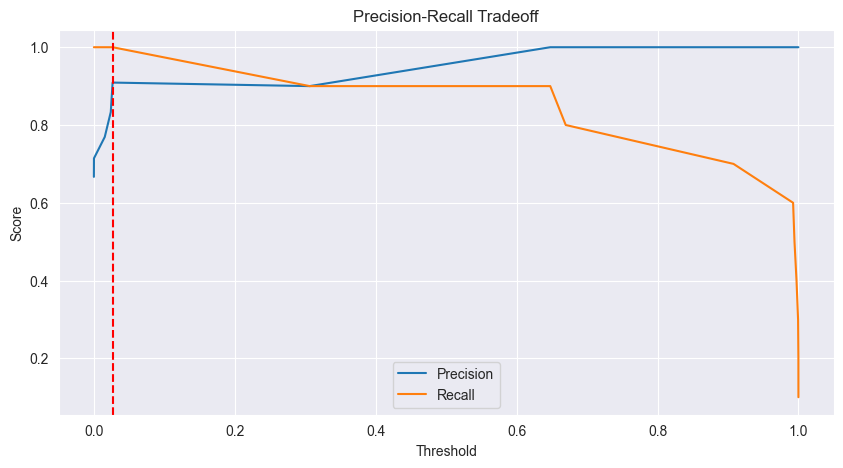

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(optimal_threshold_pr, color='r', linestyle='--')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Tradeoff')
plt.legend()
plt.show()

In [23]:
final_threshold = optimal_threshold_pr
y_pred_custom = (y_proba >= final_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")

ValueError: Found input variables with inconsistent numbers of samples: [50, 24]

In [45]:
y_pred_custom

array([1, 1, 1, 0, 0, 1, 1, 1, 0, 1])

In [46]:
y_proba

array([9.99948294e-01, 2.69027376e-02, 9.99935072e-01, 2.15013449e-07,
       7.28956514e-05, 1.59122278e-02, 9.99961485e-01, 9.99939536e-01,
       5.06101700e-08, 9.99944119e-01])